In [1]:
import sys
sys.path.insert(0, '/home/ading/dev/empirical-mt')

import matplotlib.pyplot as plt

from pelic.gabors import makeGabors, makeGaussian
from pelic.calculate_contrast import CalculateContrast

import pandas as pd

from tqdm import tqdm 

from tuning import DirectionTuning, SpeedTuning, DisparityTuning

import numpy as np

from skimage import io, transform, util, img_as_float
from skimage.color import rgb2gray, gray2rgb
from skimage.transform import resize
import skimage.draw as draw

import scipy.io as sio

import MT

from keras.layers import Input, Dense, Concatenate, Multiply
from keras.models import Model

size_ = 101
gabors = makeGabors(size_, center=None)
gaussian = makeGaussian(size_, sigma=5, center=None)

contrast_calculator = CalculateContrast(gabors, gaussian)

import tensorflow as tf

from os import listdir
from os.path import isfile, join, split, isdir, basename

from scipy import stats

Using TensorFlow backend.


In [2]:

def _rescale_on_bounding_box(f1_ann, f2_ann):
    v1, v3 = _bounding_box_map_to_coord(f1_ann[:, :, 1])

    box_size = np.max(np.abs(v1 - v3))

    scale = FIXED_SIZE * OBJ_PATCH_RATIO / box_size

    f1_ann_rescaled = transform.rescale(f1_ann, scale, order=3, anti_aliasing=True)
    f2_ann_resaled = transform.rescale(f2_ann, scale, order=3, anti_aliasing=True)

    return f1_ann_rescaled, f2_ann_resaled


def _bounding_box_map_to_coord(box):
    ann_coords = tuple(zip(*np.nonzero(box[:, :] >= 0.5)))
    return np.array((ann_coords[0], ann_coords[-1]))


def _center_on_bounding_box_and_crop(f1_ann, f2_ann):
    f1_ann_padded = util.pad(f1_ann, ((FIXED_SIZE, FIXED_SIZE), (FIXED_SIZE, FIXED_SIZE), (0, 0)), mode='constant')
    f2_ann_padded = util.pad(f2_ann, ((FIXED_SIZE, FIXED_SIZE), (FIXED_SIZE, FIXED_SIZE), (0, 0)), mode='constant')

    f1_box_v1, f1_box_v3 = _bounding_box_map_to_coord(f1_ann_padded[:, :, 1])
    f1_center = (f1_box_v1 + f1_box_v3) / 2

    f1_cropped_start = f1_center - (FIXED_SIZE / 2)
    f1_cropped_end = f1_center + (FIXED_SIZE / 2) - 1

    rr, cc = draw.rectangle(f1_cropped_start, f1_cropped_end)

    f1_cropped = f1_ann_padded[rr, cc, :]
    f1_cropped = np.fliplr(f1_cropped)
    f1_cropped = transform.rotate(f1_cropped, 90)

    f2_cropped = f2_ann_padded[rr, cc, :]
    f2_cropped = np.fliplr(f2_cropped)
    f2_cropped = transform.rotate(f2_cropped, 90)

    # make sure that the dimension is FIXED_SIZE x FIXED_SIZE
    assert (f1_cropped.shape[0:2] == (FIXED_SIZE, FIXED_SIZE)) and (f2_cropped.shape[0:2] == (FIXED_SIZE, FIXED_SIZE))

    return f1_cropped, f2_cropped


def _annotate_frame(frame, box):
    annotated = np.zeros(frame.shape + (2,))
    annotated[:, :, 0] = frame
    rr, cc = draw.rectangle(box[0], box[1])
    annotated[rr, cc, 1] = 1
    return annotated


def _parse(f1, f2, box1, box2):
    f1_ann = _annotate_frame(f1, box1 - 1)
    f2_ann = _annotate_frame(f2, box2 - 1)

    f1_ann_rescaled, f2_ann_rescaled = _rescale_on_bounding_box(f1_ann, f2_ann)
    f1_ann_centered, f2_ann_centered = _center_on_bounding_box_and_crop(f1_ann_rescaled, f2_ann_rescaled)

    f1_cropped = f1_ann_centered[:, :, 0]
    box1_cropped = _bounding_box_map_to_coord(f1_ann_centered[:, :, 1])

    f2_cropped = f2_ann_centered[:, :, 0]
    box2_cropped = _bounding_box_map_to_coord(f2_ann_centered[:, :, 1])

    return f1_cropped, f2_cropped, box1_cropped, box2_cropped

In [4]:
i = io.imread('../input/ALOV300++/imagedata++/14-LongDuration/14-LongDuration_video00003/00000897.jpg', as_gray=True)

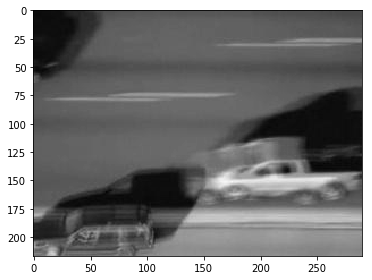

In [5]:
io.imshow(i)

plt.show()

In [6]:
df = pd.read_json('../data/alov300++/pairwise_train.json')

In [7]:
df.shape

(11625, 8)